In [1]:
!uname -a

Linux compute-0-26.local 2.6.32-642.el6.x86_64 #1 SMP Tue May 10 17:27:01 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
!pwd

/home/tallam/plasticc/snmachine/examples


In [3]:
!pip install ../.

Processing /home/tallam/plasticc/snmachine
  Running setup.py bdist_wheel for snmachine ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-biqsti0q/wheels/cd/65/db/fda56ff3f0d6fa8ba1e7b69dab8a17be3a2bbe7940a42d6151
Successfully built snmachine
  Found existing installation: snmachine 1.1.1
    Uninstalling snmachine-1.1.1:
      Successfully uninstalled snmachine-1.1.1


# Notebook for running the snmachine pipeline on PLAsTiCC simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the photometric light-curve astronomical time-series classification challenge (PLAsTiCC). 

See Lochner et al. (2016) http://arxiv.org/abs/1603.00882 for the original SPCC-challenge test.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [6]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
from snmachine import sndata, snfeatures, snclassifier, tsne_plot
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack,unique
from astropy.io import fits
import sklearn.metrics 
import sncosmo
import pickle
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Set the number of processes you want to use throughout the notebook
import multiprocessing
num_cpu = multiprocessing.cpu_count()
nproc=num_cpu
print("Running with {} cores".format(num_cpu))

Running with 40 cores


## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

## Initialise dataset object

Load a subset of the PLAsTiCC simulated data (https://arxiv.org/abs/1810.00001)

In [8]:
# Please specify Data root, 
# the path to where you have pulled all the data from
rt='/share/hypatia/snmachine_resources/data/cwp/WFDY10/RH_kraken_2026_wfd_WFD_1aONLY_Y10_G10/'
prefixIa='RH_WFD_1aONLY_Y10_G10_Ia-'
prefixNONIa='RH_WFD_1aONLY_Y10_G10_NONIa-'
# Name for the dataset
dataset='kraken_2026_wfd_Y10'

In [9]:
# WARNING...
#Multinest uses a hardcoded character limit for the output file names. I believe it's a limit of 100 characters
#so avoid making this file path to lengthy if using nested sampling or multinest output file names will be truncated

#Change outdir to somewhere on your computer if you like
# outdir=os.path.join('output_{}_no_z'.format(dataset),'')
outdir="/share/hypatia/snmachine_resources/data/LSST_Cadence_WhitePaperClassResults/output_data/revision/output_{}_no_z/".format(dataset)

out_features=os.path.join(outdir,'features') #Where we save the extracted features to
out_class=os.path.join(outdir,'classifications') #Where we save the classification probabilities and ROC curves
out_int=os.path.join(outdir,'int') #Any intermediate files (such as multinest chains or GP fits)

subprocess.call(['mkdir',outdir])
subprocess.call(['mkdir',out_features])
subprocess.call(['mkdir',out_class])
subprocess.call(['mkdir',out_int])

1

In [10]:
import random
SEED=1234
random.seed(SEED)
chunks = random.sample(range(1, 21), 1)
chunks

[15]

In [11]:
dat=sndata.LSSTCadenceSimulations(folder=rt,prefix_Ia=prefixIa, prefix_NONIa=prefixNONIa, indices=chunks)
#dat=sndata.plasticc_data(folder=rt,pickle_file='dataset_full.pickle',from_pickle=True)

Reading data...
chunk 15
0k
10k
20k
30k
40k
50k
60k
70k
80k
90k
100k
110k
120k
130k
140k
150k
160k
170k
175475 objects read into memory.


Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


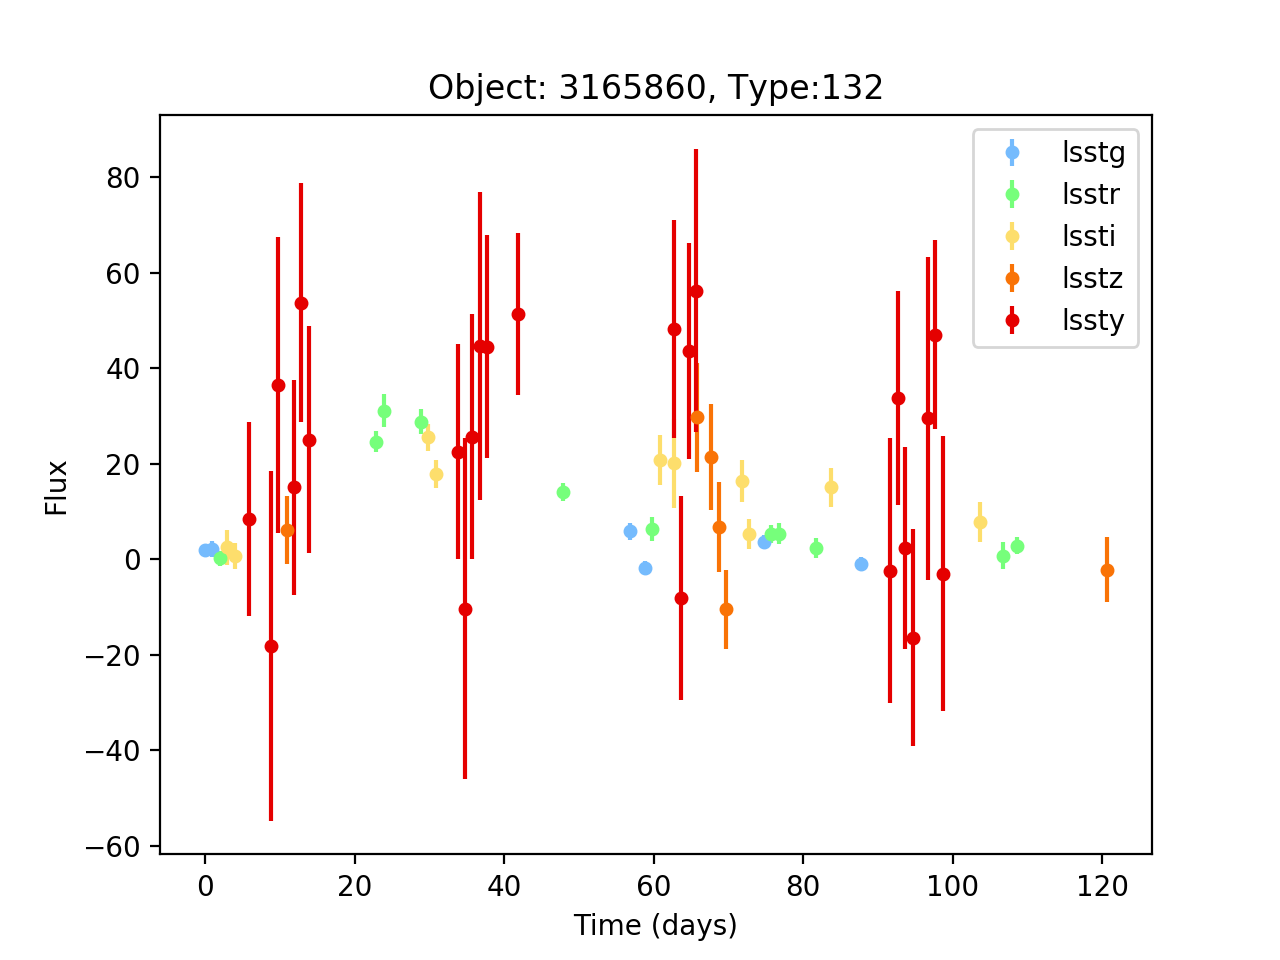

In [12]:
dat.plot_all(mix=True, sep_detect=False)

In [15]:
# Get the types, note these are internal snmachine datatypes
types=dat.get_types()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

Note: The types listed here in the table the internal types to snmachine

In [16]:
_, reds=dat.get_redshift()
reds[:10]

Object,Redshift
str8,float32
3165860,0.47049
3523353,0.471443
25354848,0.273423
31961787,0.301334
12190510,0.567295
61879592,0.470988
66380112,-9.0
31460526,-9.0
27754166,-9.0


### Define subset

In [17]:
# Get object names from data
# total_objects = dat.object_names[:]
# print(total_objects)
# np.random.seed(SEED)
# np.random.shuffle(total_objects)
# print(total_objects)

In [19]:
# Turn this into a Python list
# total_set = list(total_objects)
# print(type(total_set)) # Should be a list

In [36]:
# Randomly select 22000 objects from this Python list of objects, OR chose a
# float between 0 and 1 of the percentage of the training set to use.
# reduced_set = total_objects[:22000]
# with open(outdir+'{}_reduced_set.txt'.format(dataset), 'w') as f:
#     for item in reduced_set:
#         f.write("%s\n" % item)
        
subset_file = outdir+'{}_reduced_set.txt'.format(dataset)
if os.path.exists(subset_file):
    rand_objs = np.genfromtxt(subset_file, dtype='U')
else:
    np.random.seed(SEED)
    rand_objs = np.random.choice(dat.object_names, replace=False, size=22000)
    np.savetxt(subset_file, rand_objs, fmt='%s')

In [37]:
#list(reduced_set)
# subset = list(map(int, reduced_set))
len(rand_objs)

22000

In [38]:
dat.object_names = rand_objs

In [39]:
dat.object_names.shape[0]

22000

In [40]:
# Get object names from data
new_total_objects = dat.object_names[:]
print(len(new_total_objects))
np.random.shuffle(new_total_objects)
print(new_total_objects)

# Turn this into a Python list
new_total_set = list(new_total_objects)
print(type(new_total_set)) # Should be a list

# Now choose a random selection for the training
training_set = new_total_set[:2000]
len(training_set)

2000

### Inspect GP fitting capability for individual objects

<IPython.core.display.Javascript object>


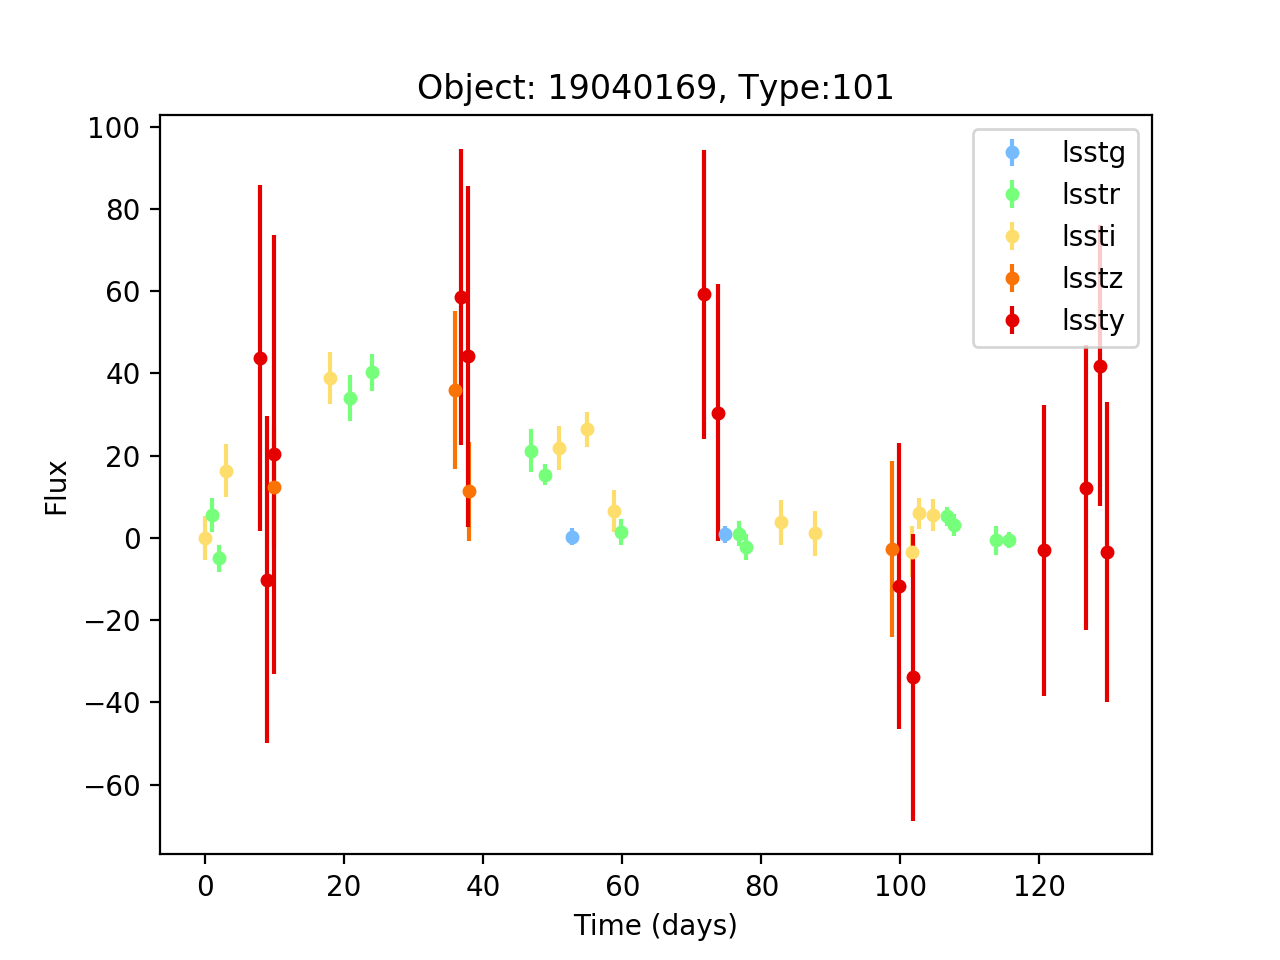

In [41]:
#test_obj = '3211874' # a nice Ia
test_obj = dat.object_names[23]
test_obj
plt.figure()
dat.plot_lc(test_obj, plot_model=True)

<IPython.core.display.Javascript object>


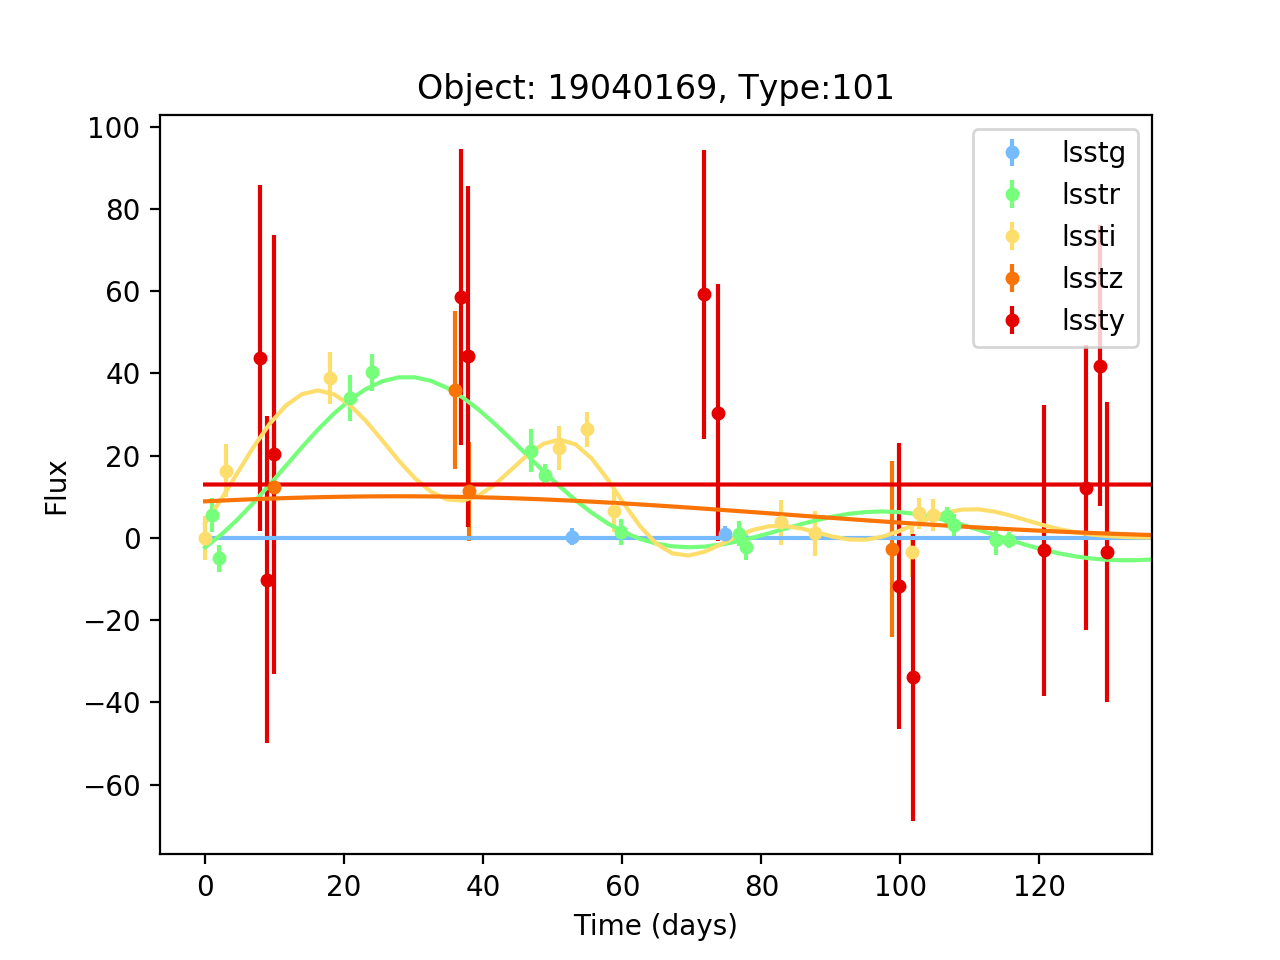

In [44]:
sn = dat.data[test_obj]
g=snfeatures._GP(test_obj, dat,ngp=100,xmin=0,xmax=dat.get_max_length(),initheta=[500,20], save_output=True, output_root=os.path.join(outdir, 'int', ''))
dat.models[test_obj] = g
type(dat)
#dat.plot_lc(test_obj, plot_model=True)
plt.figure()
dat.plot_lc(test_obj, plot_model=True)

In [45]:
chi_dict = dat.reduced_chi_squared([test_obj])
chi_dict

{'19040169': 0.54677521418472219}

## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file (`snmachine` by default saves to astropy tables)

In [46]:
read_from_file=False #We can use this flag to quickly rerun from saved features
run_name=os.path.join(out_features,'{}_all'.format(dataset))
read_from_pickle=False
pickle_location = rt
restart_from_GP = False
restart_from_wavefeats=False
restart_from_wavelets=False

### Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [47]:
#waveFeats=snfeatures.WaveletFeatures()
wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)

In [49]:
#%%capture --no-stdout
if read_from_file:
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)
elif read_from_pickle:
    print('THIS IS NOT CURRENTLY IMPLEMENTED')
    f = open(rt)
    wave_features=Table.read('%s_wavelets.dat' %run_name, format='ascii')
    #Crucial for this format of id's
    blah=wave_features['Object'].astype(str)
    wave_features.replace_column('Object', blah)
    PCA_vals=np.loadtxt('%s_wavelets_PCA_vals.dat' %run_name)
    PCA_vec=np.loadtxt('%s_wavelets_PCA_vec.dat' %run_name)
    PCA_mean=np.loadtxt('%s_wavelets_PCA_mean.dat' %run_name)

elif restart_from_GP:
    wave_features=waveFeats.extract_features(dat,nprocesses=nproc,output_root=rt,save_output='all',restart='gp')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,waveFeats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,waveFeats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,waveFeats.PCA_mean)
    
    PCA_vals=waveFeats.PCA_eigenvals
    PCA_vec=waveFeats.PCA_eigenvectors
    PCA_mean=waveFeats.PCA_mean
    
elif restart_from_wavefeats:
    wave_features=Table.read(rt  + 'wavelet_features.fits',format='fits')
    wave_features.write('%s_wavelets.dat' %run_name, format='ascii')
    f = open(rt+'PCA_eigenvals.pickle','rb')
    PCA_vals=pickle.load(f)
    f.close()
    f = open(rt+'PCA_eigenvectors.pickle','rb')
    PCA_vec=pickle.load(f)
    f.close()
    f = open(rt+'PCA_mean.pickle','rb')
    PCA_mean=pickle.load(f)
    f.close()
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,PCA_vals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,PCA_vec)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,PCA_mean)

elif restart_from_wavelets:
    # RESTART FROM WAVELETS
    # Copy int to finaldir and read in raw wavelets
    wavelet_feats=snfeatures.WaveletFeatures(wavelet='sym2', ngp=100)
    wave_raw, wave_err=wavelet_feats.restart_from_wavelets(dat, os.path.join(outdir, 'int', ''))
    wavelet_features,vals,vec,means=wavelet_feats.extract_pca(dat.object_names.copy(), wave_raw)

else:
    wavelet_features=wavelet_feats.extract_features(dat,nprocesses=nproc,output_root=out_int,save_output='all')
    wavelet_features.write('%s_wavelets.dat' %run_name, format='ascii')
    np.savetxt('%s_wavelets_PCA_vals.dat' %run_name,wavelet_feats.PCA_eigenvals)
    np.savetxt('%s_wavelets_PCA_vec.dat' %run_name,wavelet_feats.PCA_eigenvectors)
    np.savetxt('%s_wavelets_PCA_mean.dat' %run_name,wavelet_feats.PCA_mean)
    
    vals=wavelet_feats.PCA_eigenvals
    vec=wavelet_feats.PCA_eigenvectors
    means=wavelet_feats.PCA_mean

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/astropy/table/table.py:2622: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other


In [50]:
wavelet_feats

In [51]:
#dat.set_model(waveFeats.fit_sn,wave_features,PCA_vec,PCA_mean,0,dat.get_max_length(),dat.filter_set)
dat.set_model(wavelet_feats.fit_sn,wavelet_features,vec,means,0,dat.get_max_length(),dat.filter_set)

<IPython.core.display.Javascript object>


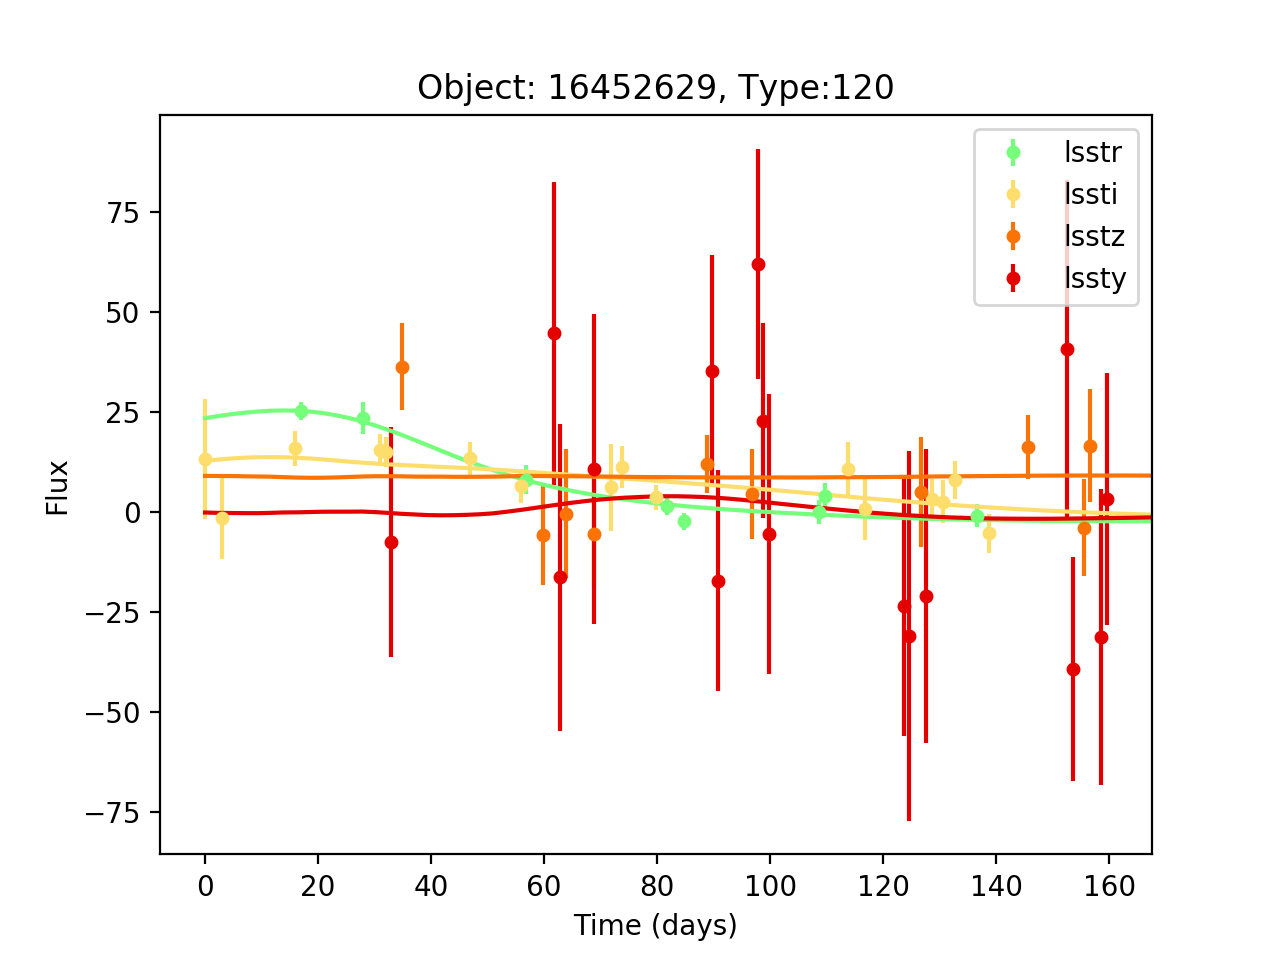

In [52]:
dat.plot_all(mix=True)

### Chi Squared Histogram

We want to double check the GP's have been fit well.

In [53]:
chi_dict = dat.reduced_chi_squared(training_set)
chi_dict

{'56208437': 1.1805639782744421,
 '75369753': 1.7642521038172245,
 '24520172': 0.60378661992747695,
 '3337345': 0.62068446350825979,
 '36488667': 0.83968969561609552,
 '39324944': 0.99503791853193724,
 '43566104': 0.55216970886968919,
 '23638532': 0.64060111315107926,
 '47137144': 2.2964702402614519,
 '15681971': 1.8798473916309342,
 '50290926': 2.6546103164871853,
 '27538908': 0.82219500289155623,
 '12229002': 0.75048851482791312,
 '56328224': 2.6909241582391119,
 '52364928': 0.59639361899496901,
 '63368103': 0.88522447677372784,
 '51601183': 0.59858333783287354,
 '66486617': 0.91923177002830958,
 '9009981': 1.0540383050819544,
 '71965940': 13.442703535684419,
 '20892453': 0.63143559849757602,
 '38948155': 0.35119552679380822,
 '8943788': 1.0513776863384265,
 '19040169': 1.5321706376162587,
 '30921723': 1.1545389421947791,
 '70284546': 1.0269923192269814,
 '54866464': 6.5107614355619212,
 '38941292': 1.3686530373151926,
 '38266927': 4.67951302514318,
 '76023415': 1.1042237866327695,
 

<IPython.core.display.Javascript object>


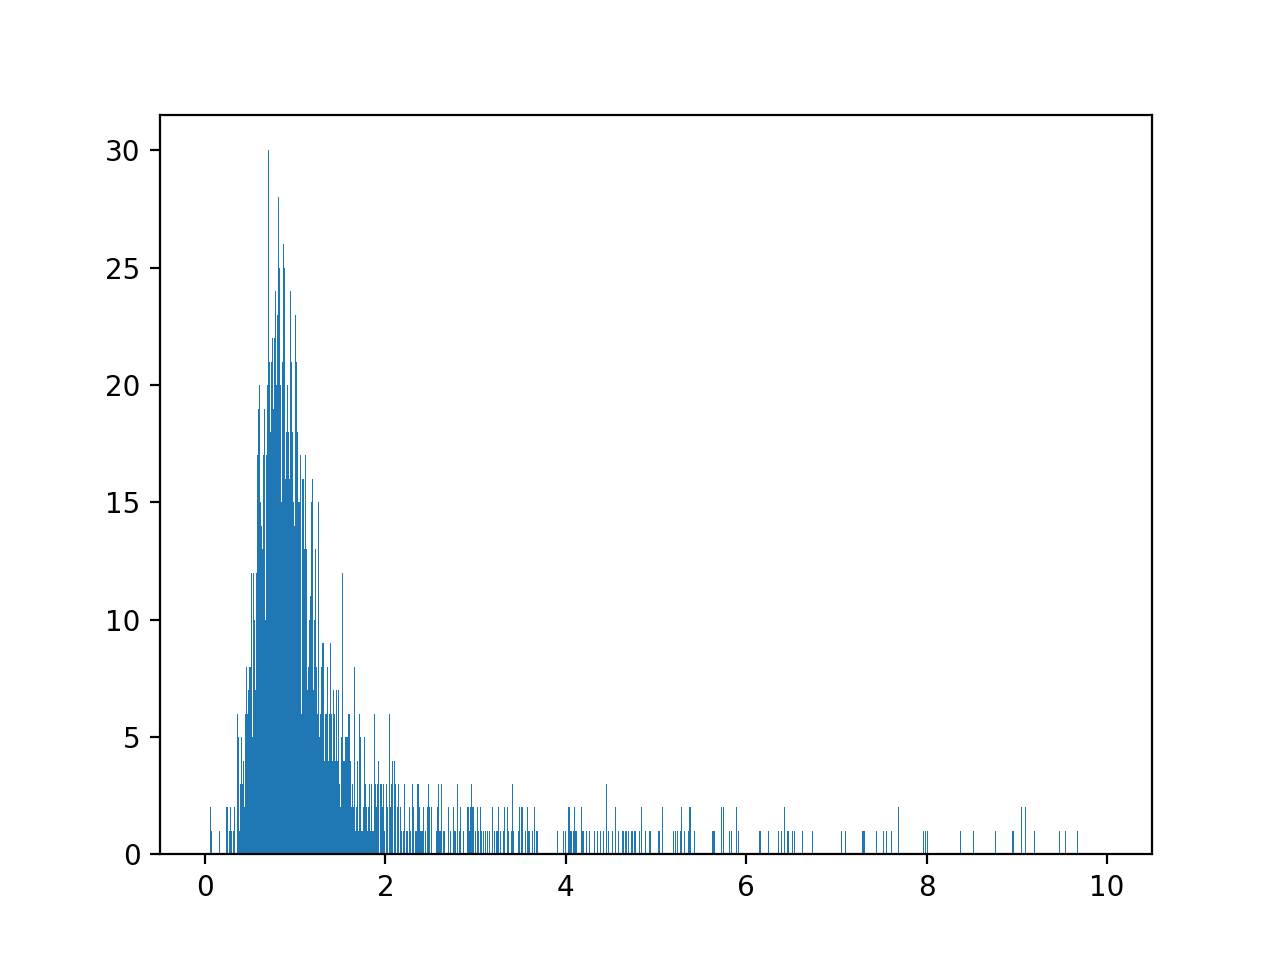

In [54]:
plt.figure(99)
plt.hist(chi_dict.values(), bins=1000, range=(0.0, 10))
plt.show()

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change this parameter to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [55]:
#Available classifiers 
print(snclassifier.choice_of_classifiers)

### SPCC-like pre-processing

In [56]:
# Like for SPCC example notebook where we restrict ourselves to three supernova types:
# Ia (1), II (2) and Ibc (3) by carrying out the following pre-proccessing steps
types['Type'] = types['Type']-100

types['Type'][np.floor(types['Type']/10)==2]=2
types['Type'][np.floor(types['Type']/10)==3]=3
types['Type'][np.floor(types['Type']/10)==4]=2

<IPython.core.display.Javascript object>


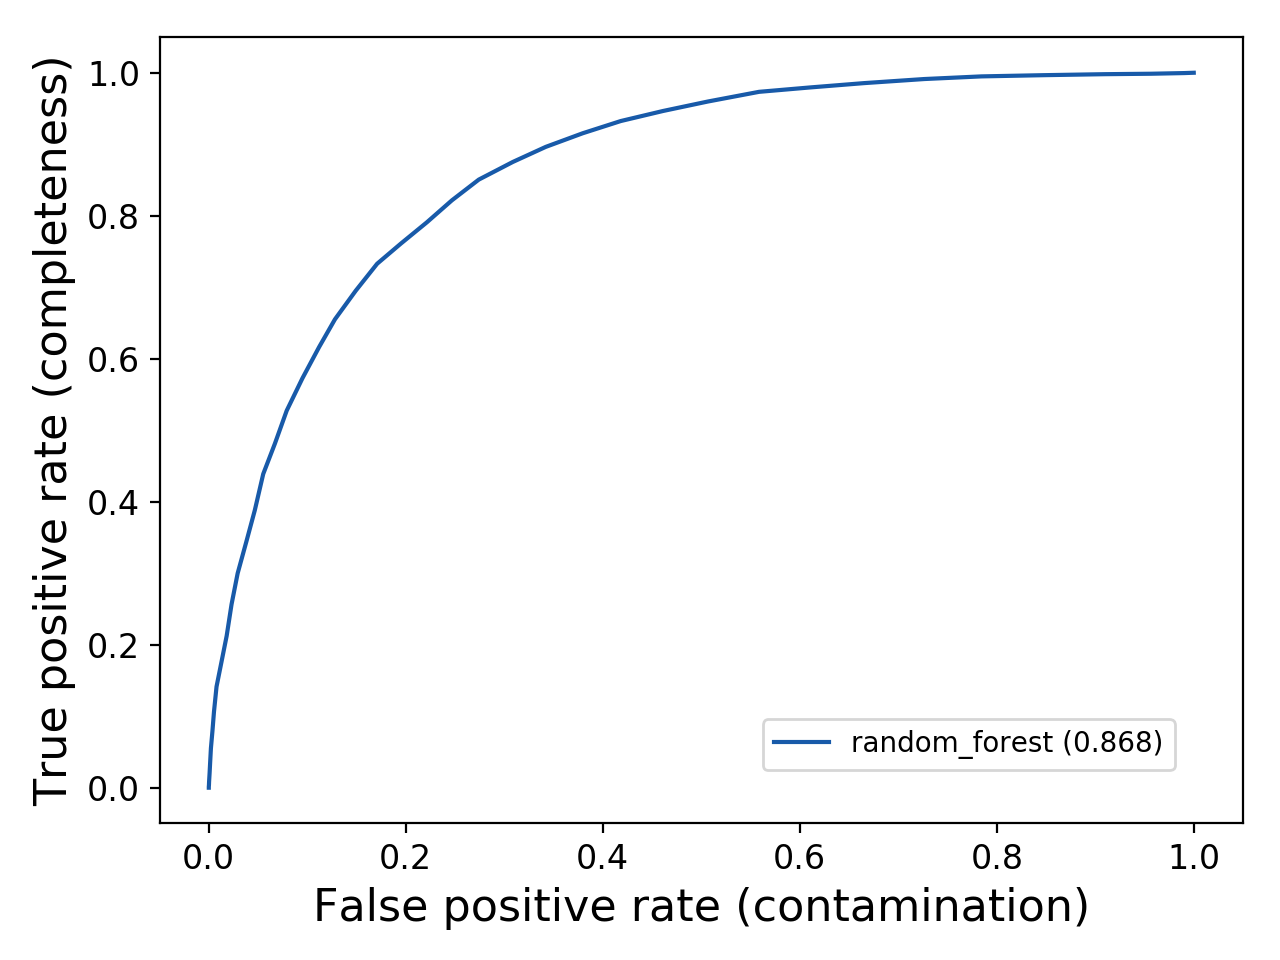

/home/tallam/.conda/envs/snmplasticc/lib/python3.6/site-packages/snmachine/snclassifier.py:130: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(cols)


In [57]:
fig = plt.figure()
clss, cms=snclassifier.run_pipeline(wavelet_features,types,output_name=os.path.join(out_class,'wavelets'),
                          training_set=training_set, classifiers=['random_forest'], nprocesses=nproc, 
                            return_classifier=True, classifiers_for_cm_plots='all')

### Plot confusion matrix

In [58]:
import seaborn as sns
from astropy.table import Table,join,unique

<IPython.core.display.Javascript object>


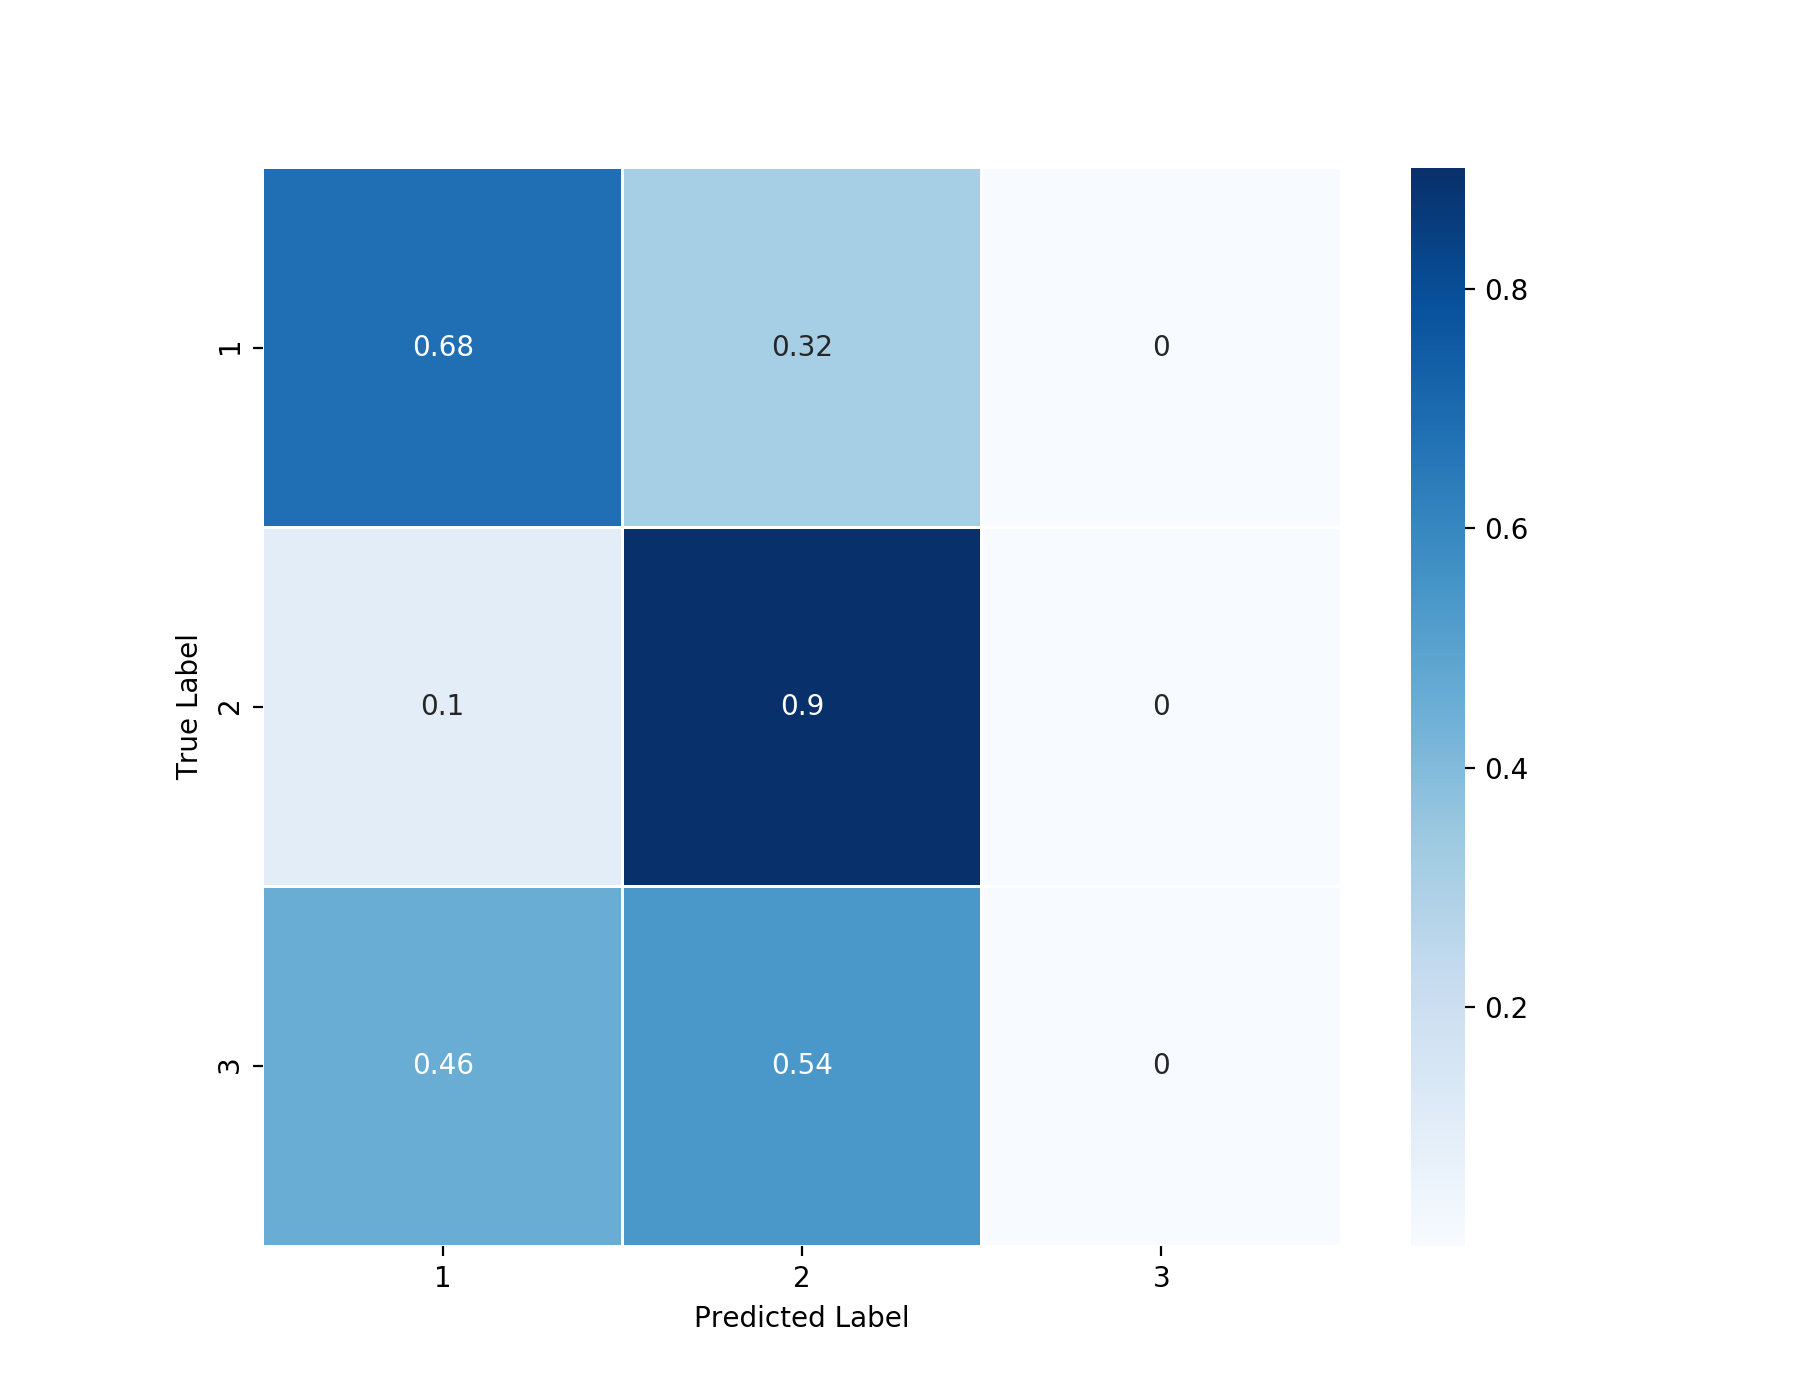

In [59]:
cm = cms[0]
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

labels=[]
for tp_row in unique(types, keys='Type'):
    labels.append(tp_row['Type'])

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')